# Background fit 

### Non-Resonant background 

Non-resonant backgrounds are
1. GJetPt20To40
3. GGJets
4. GJetPt40



## GGJets

In [35]:
import os
import pandas as pd
import uproot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ROOT

In [36]:
signal = [
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GGJets/preselection")
]

In [37]:
keys  = ['diphoton_mass', 'dibjet_mass', 'bbgg_mass']

In [38]:
# Load DataFrames
dfs = {}

# Load lowX files
for file, key in signal:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")


In [39]:
# Extracting the specific dataframe
NMSSM_X400_Y125_preselection = dfs["/GGJets/preselection"]

# Define each variable separately
diphoton_mass = NMSSM_X400_Y125_preselection["diphoton_mass"]
dibjet_mass = NMSSM_X400_Y125_preselection["dibjet_mass"]
bbgg_mass = NMSSM_X400_Y125_preselection["bbgg_mass"]

In [40]:
bbgg_mass

0          309.540767
1          164.676357
2          255.053183
3          489.821610
4          239.716544
              ...    
3242390    215.846447
3242391    373.464248
3242392    213.616287
3242393    392.107211
3242394    752.292951
Name: bbgg_mass, Length: 3242395, dtype: float64

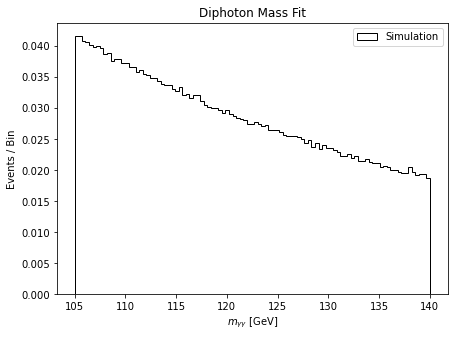

In [41]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk


# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
# plt.plot(x_fit, y_fit, color="blue", label="Gaussian Fit")
# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit")
plt.show()

In [42]:
len(bin_centers)

99

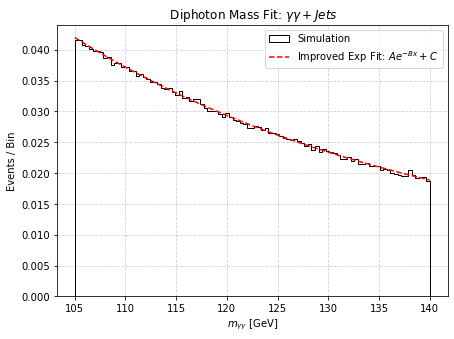

Fitted Parameters: A = 0.679, B = 0.02764, C = 0.00472


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[1, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Plot histogram and improved fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title(" Diphoton Mass Fit: $\gamma\gamma+Jets$")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.png")
plt.show()
# Print improved fit parameters
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")


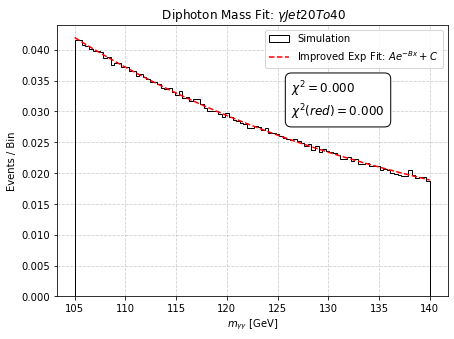

Fitted Parameters: A = 0.679, B = 0.02764, C = 0.00472
Chi-squared: 0.000, Degrees of Freedom: 68, Reduced Chi-squared: 0.000


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[0.08, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Calculate chi-squared
y_fit_data = exp_fit(bin_centers[fit_mask], *params)
residuals = hist[fit_mask] - y_fit_data
errors = np.sqrt(hist[fit_mask])  # Assuming Poisson errors (sqrt of counts)

# Avoid division by zero in case of empty bins
errors[errors == 0] = 1  

chi2 = np.sum((residuals / errors) ** 2)
ndof = len(hist[fit_mask]) - len(params)  # Degrees of freedom

chi2_red = chi2 / ndof if ndof > 0 else np.nan  # Avoid division by zero

# Plot histogram and improved fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title(r" Diphoton Mass Fit: $\gamma Jet20To40$")
plt.grid(True, linestyle="--", alpha=0.6)

# Add chi-squared and reduced chi-squared to the plot
plt.text(0.6, 0.8, f"$\chi^2 = {chi2:.3f}$\n$\chi^2(red) = {chi2_red:.3f}$", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet20To40.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet20To40.png")
plt.show()

# Print improved fit parameters and chi-squared
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")
print(f"Chi-squared: {chi2:.3f}, Degrees of Freedom: {ndof}, Reduced Chi-squared: {chi2_red:.3f}")


In [45]:
# Save the fitted shape (histogram) to a ROOT file
root_file_path = "fitting_results.root"

# Create a new ROOT file
root_file = ROOT.TFile(root_file_path, "UPDATE")

# Create a histogram for the fitted function
hist_fit = ROOT.TH1F("GGJets", "Fitted DSCB Shape", len(bin_edges)-1, bin_edges)

# Fill the histogram with the fitted function values
for i in range(len(bin_centers)):
    hist_fit.SetBinContent(i+1, y_fit[i])

# Save the histogram to the ROOT file
hist_fit.Write()

# Close the ROOT file
root_file.Close()

print(f"Fitted histogram saved to {root_file_path}")



Fitted histogram saved to fitting_results.root


## GJetPt40

In [46]:
import uproot
import awkward as ak
from vector import Array as awk
import numpy as np

# Path to the ROOT file and tr/ee
file_path_signal = "../../../output_root/v2_production/backgrounds/GJetPt40.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)


# Compute diphoton mass from its Lorentz vector
diphoton_mass = diphoton_.mass


diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Convert extracted variabless to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
# dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dijet_mass - 125)

## Updated bins and the mass windows

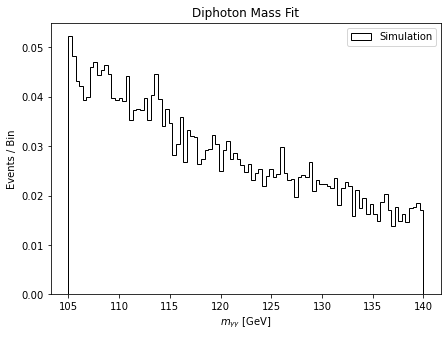

In [47]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk


# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
# plt.plot(x_fit, y_fit, color="blue", label="Gaussian Fit")
# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit")
plt.show()

perfoming exponential fit on the mass ranges of 105-140 Gev, reason 
for choosing the above range because to avoid the turn-on in the backgrounds.
### Exponentail fit


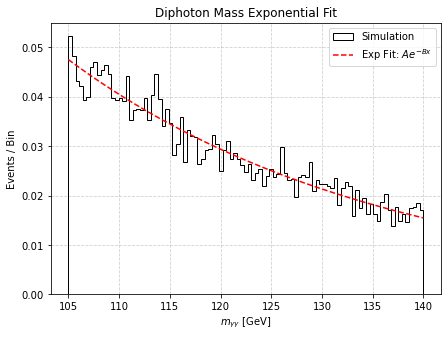

Fitted Parameters: A = 1.375, B = 0.03205


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential function for fitting
def exp_fit(x, A, B):
    return A * np.exp(-B * x)

# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass_np, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# Fit histogram data to exponential function
params, covariance = curve_fit(exp_fit, bin_centers, hist, p0=[1, 0.01])

# Generate fitted curve
x_fit = np.linspace(105, 140, 500)
y_fit = exp_fit(x_fit, *params)

# Plot histogram and exponential fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass_np, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Exp Fit: $A e^{-Bx}$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Exponential Fit")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot

plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.png")
plt.show()
# Print fit parameters
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}")


In [49]:
# Exponential fitting

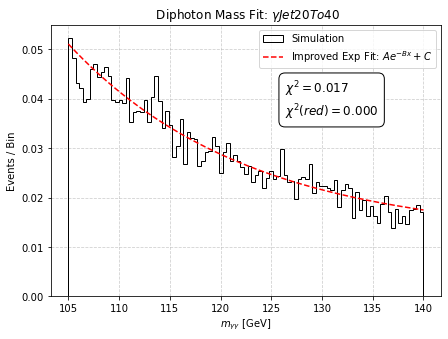

Fitted Parameters: A = 15.063, B = 0.05675, C = 0.01215
Chi-squared: 0.017, Degrees of Freedom: 68, Reduced Chi-squared: 0.000


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[0.08, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Calculate chi-squared
y_fit_data = exp_fit(bin_centers[fit_mask], *params)
residuals = hist[fit_mask] - y_fit_data
errors = np.sqrt(hist[fit_mask])  # Assuming Poisson errors (sqrt of counts)

# Avoid division by zero in case of empty bins
errors[errors == 0] = 1  

chi2 = np.sum((residuals / errors) ** 2)
ndof = len(hist[fit_mask]) - len(params)  # Degrees of freedom

chi2_red = chi2 / ndof if ndof > 0 else np.nan  # Avoid division by zero

# Plot histogram and improved fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title(r" Diphoton Mass Fit: $\gamma Jet20To40$")
plt.grid(True, linestyle="--", alpha=0.6)

# Add chi-squared and reduced chi-squared to the plot
plt.text(0.6, 0.8, f"$\chi^2 = {chi2:.3f}$\n$\chi^2(red) = {chi2_red:.3f}$", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet40.png")
plt.show()

# Print improved fit parameters and chi-squared
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")
print(f"Chi-squared: {chi2:.3f}, Degrees of Freedom: {ndof}, Reduced Chi-squared: {chi2_red:.3f}")


In [6]:
import ROOT
# Save the fitted shape (histogram) to a ROOT file
root_file_path = "fitting_results.root"

# Create a new ROOT file
root_file = ROOT.TFile(root_file_path, "UPDATE")

# Create a histogram for the fitted function
hist_fit = ROOT.TH1F("GJetPt40", "Fitted DSCB Shape", len(bin_edges)-1, bin_edges)

# Fill the histogram with the fitted function values
for i in range(len(bin_centers)):
    hist_fit.SetBinContent(i+1, y_fit[i])

# Save the histogram to the ROOT file
hist_fit.Write()

# Close the ROOT file
root_file.Close()

print(f"Fitted histogram saved to {root_file_path}")



Welcome to JupyROOT 6.30/02
Fitted histogram saved to fitting_results.root


In [ ]:
# uncertainity

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define histogram binning
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass_np, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

# Define the fit range (focus on mid-range)
fit_mask = (bin_centers > 110) & (bin_centers < 135)

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[1, 0.01, 0])

# Extract fit parameters and uncertainties
A_fit, B_fit, C_fit = params
A_err, B_err, C_err = np.sqrt(np.diag(covariance))  # Uncertainties

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, A_fit, B_fit, C_fit)

# Generate uncertainty bands using Monte Carlo sampling
num_samples = 1000
y_samples = np.array([exp_fit(x_fit, 
                              np.random.normal(A_fit, A_err), 
                              np.random.normal(B_fit, B_err), 
                              np.random.normal(C_fit, C_err)) 
                      for _ in range(num_samples)])

y_err_up = np.percentile(y_samples, 84, axis=0)  # +1σ (Upper bound)
y_err_down = np.percentile(y_samples, 16, axis=0)  # -1σ (Lower bound)

# Plot histogram
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass_np, bins=bins, density=True, histtype="step", color="black", label="Simulation")

# Plot fit and hatched uncertainty bands
plt.plot(x_fit, y_fit, color="red", linestyle="-", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Apply hatched pattern to uncertainty band
plt.fill_between(x_fit, y_err_down, y_err_up, 
                 facecolor="none", edgecolor="red", hatch="\\", alpha=0.5, label="Fit Uncertainty (±1σ)")

# Labels and CMS-style formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Improved Diphoton Mass Fit with Uncertainty")
plt.grid(True, linestyle="--", alpha=0.6)

# Save the plot
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/nonres_fitting_GJet40_with_hatch_uncertainty.pdf")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/nonres_fitting_GJet40_with_hatch_uncertainty.png")
plt.show()

# Print fit parameters with uncertainties
print(f"Fitted Parameters: A = {A_fit:.3f} ± {A_err:.3f}, B = {B_fit:.5f} ± {B_err:.5f}, C = {C_fit:.5f} ± {C_err:.5f}")


In [ ]:
# Scatter plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[1, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Plot simulation data as circles
plt.figure(figsize=(7, 5))
plt.scatter(bin_centers, hist, color="black", marker='o', label="Simulation", alpha=0.8)

# Plot the fitted curve
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Improved Diphoton Mass Fit")
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/Scatter_fitting_GJet40.pdf")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/Scatter_fitting_GJet40.png")
plt.show()
# Print improved fit parameters
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")


# GJetPt20To40

In [51]:
GJetPt20To40 = [
    ("../../outputfiles/hhbbgg_analyzer-v2-trees.root", "/GJetPt20To40/preselection")
]

In [52]:
keys  = ['diphoton_mass', 'dibjet_mass', 'bbgg_mass']

In [53]:
# Load DataFrames
dfs = {}

# Load lowX files
for file, key in GJetPt20To40:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")


In [54]:
# Extracting the specific dataframe
GJetPt20To40_preselection = dfs["/GJetPt20To40/preselection"]

# Define each variable separately
diphoton_mass = GJetPt20To40_preselection["diphoton_mass"]
dibjet_mass = GJetPt20To40_preselection["dibjet_mass"]
bbgg_mass = GJetPt20To40_preselection["bbgg_mass"]

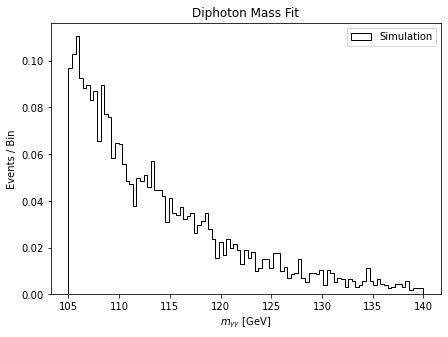

In [55]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk


# Create histogram
bins = np.linspace(105, 140, 100)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
# plt.plot(x_fit, y_fit, color="blue", label="Gaussian Fit")
# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit")
plt.show()

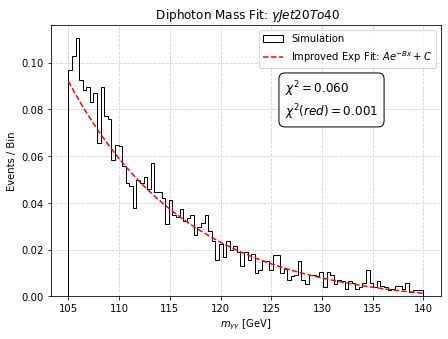

Fitted Parameters: A = 709.745, B = 0.08488, C = -0.00357
Chi-squared: 0.060, Degrees of Freedom: 68, Reduced Chi-squared: 0.001


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define improved exponential function with an additional constant
def exp_fit(x, A, B, C):
    return A * np.exp(-B * x) + C

# Define the fit range
fit_mask = (bin_centers > 110) & (bin_centers < 135)  # Focus on mid-range

# Perform fit using selected range
params, covariance = curve_fit(exp_fit, bin_centers[fit_mask], hist[fit_mask], p0=[0.08, 0.01, 0])

# Generate fitted curve
x_fit = np.linspace(105, 140, 1000)
y_fit = exp_fit(x_fit, *params)

# Calculate chi-squared
y_fit_data = exp_fit(bin_centers[fit_mask], *params)
residuals = hist[fit_mask] - y_fit_data
errors = np.sqrt(hist[fit_mask])  # Assuming Poisson errors (sqrt of counts)

# Avoid division by zero in case of empty bins
errors[errors == 0] = 1  

chi2 = np.sum((residuals / errors) ** 2)
ndof = len(hist[fit_mask]) - len(params)  # Degrees of freedom

chi2_red = chi2 / ndof if ndof > 0 else np.nan  # Avoid division by zero

# Plot histogram and improved fit
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label=r"Improved Exp Fit: $A e^{-Bx} + C$")

# Labels and formatting
plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title(r" Diphoton Mass Fit: $\gamma Jet20To40$")
plt.grid(True, linestyle="--", alpha=0.6)

# Add chi-squared and reduced chi-squared to the plot
plt.text(0.6, 0.8, f"$\chi^2 = {chi2:.3f}$\n$\chi^2(red) = {chi2_red:.3f}$", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet20To40.pdf")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/stat_study/background_diphoton/fitting_GJet20To40.png")
plt.show()

# Print improved fit parameters and chi-squared
print(f"Fitted Parameters: A = {params[0]:.3f}, B = {params[1]:.5f}, C = {params[2]:.5f}")
print(f"Chi-squared: {chi2:.3f}, Degrees of Freedom: {ndof}, Reduced Chi-squared: {chi2_red:.3f}")


In [13]:
import ROOT
# Save the fitted shape (histogram) to a ROOT file
root_file_path = "fitting_results.root"

# Create a new ROOT file
root_file = ROOT.TFile(root_file_path, "UPDATE")

# Create a histogram for the fitted function
hist_fit = ROOT.TH1F("GJetPt20To40", "Fitted DSCB Shape", len(bin_edges)-1, bin_edges)

# Fill the histogram with the fitted function values
for i in range(len(bin_centers)):
    hist_fit.SetBinContent(i+1, y_fit[i])

# Save the histogram to the ROOT file
hist_fit.Write()

# Close the ROOT file
root_file.Close()

print(f"Fitted histogram saved to {root_file_path}")



Fitted histogram saved to fitting_results.root
